### Library import

In [757]:
# Library import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

### Loading the dataset

In [758]:
# Load the data
# data file is located in folder data
df = pd.read_csv('./data/heart.csv')
print(df.head())
print(df.tail())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
913   45   M            TA        110          264          0     Normal   
914   68   M           ASY        144          193     

### Verify for null values and data types of each feature

In [759]:
# Check if the dataset has any missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


### Conversion of categorical variables into numeric values

In [760]:
# Map sex category variable to numeric values
# (0 denote Male and 1 denote Female)
mapping = {'M':0, 'F':1}
df['Sex'] = df['Sex'].replace(mapping)
df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 86.2+ KB
   Age  Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0   40    0           ATA        140          289          0     Normal   
1   49    1           NAP        160          180   

In [761]:
# Find unique values for chest pain type
print(df['ChestPainType'].unique())

['ATA' 'NAP' 'ASY' 'TA']


In [762]:
# Map chest pain type category variable to numeric values
# 0 denote atypical angina (ATA)
# 1 denote non-anginal pain (NAP)
# 2 denote asymptomatic (ASY)
# 3 denote typical angina (TA)
mapping = {'ATA':0, 'NAP':1, 'ASY':2, 'TA':3}
df['ChestPainType'] = df['ChestPainType'].replace(mapping)
df.info()
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 86.2+ KB
   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0   40    0              0        140          289          0     Normal   
1   49    1              1        160          180

In [763]:
# Find unique values for resting ECG
print(df['RestingECG'].unique())


['Normal' 'ST' 'LVH']


In [764]:
# Map resting ECG category variable to numeric values
# 0 denote Normal
# 1 denote ST-T wave abnormality (ST)
# 2 denote left ventricular hypertrophy (LVH)
mapping = {'Normal':0, 'ST':1, 'LVH':2}
df['RestingECG'] = df['RestingECG'].replace(mapping)
df.info()
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(9), object(2)
memory usage: 86.2+ KB
   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    0              0        140          289          0           0   
1   49    1              1        160          1

In [765]:
# Map exercise angina category variable to numeric values
# 0 denote No
# 2 denote Yes
mapping = {'N':0, 'Y':1}
df['ExerciseAngina'] = df['ExerciseAngina'].replace(mapping)
df.info()
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 86.2+ KB
   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    0              0        140          289          0           0   
1   49    1              1        160          

In [766]:
# Find unique values for resting ECG
print(df['ST_Slope'].unique())


['Up' 'Flat' 'Down']


In [767]:
# Map resting ECG category variable to numeric values
# 0 denote Up
# 1 denote Flat
# 2 denote Down
mapping = {'Up': 0, 'Flat': 1, 'Down': 2}
df['ST_Slope'] = df['ST_Slope'].replace(mapping)
df.info()
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    int64  
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 86.2 KB
   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    0              0        140          289          0           0   
1   49    1              1        160          180         

### Descriptive statistics

In [768]:
df.describe()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.210240,1.452070,132.396514,198.799564,0.233115,0.603486,136.809368,0.404139,0.887364,0.638344,0.553377
std,9.432617,0.407701,0.851832,18.514154,109.384145,0.423046,0.805968,25.460334,0.490992,1.066570,0.607056,0.497414
min,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,0.000000,1.000000,120.000000,173.250000,0.000000,0.000000,120.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,0.000000,2.000000,130.000000,223.000000,0.000000,0.000000,138.000000,0.000000,0.600000,1.000000,1.000000
75%,60.000000,0.000000,2.000000,140.000000,267.000000,0.000000,1.000000,156.000000,1.000000,1.500000,1.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,1.000000


### Check for balance dataset

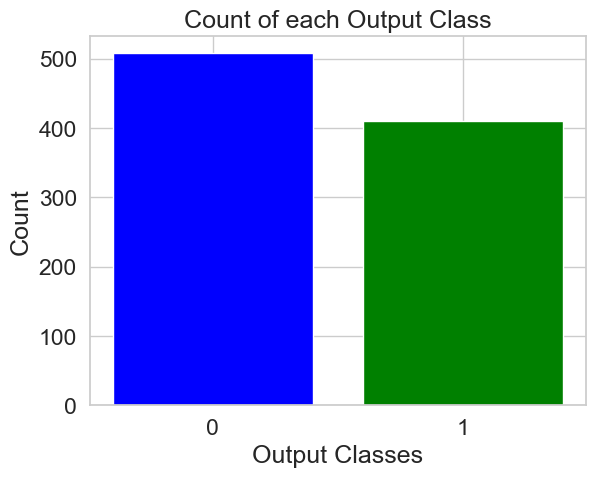

In [769]:
# Check if the dataset is balanced
# Count the number of Heart Disease (1) and Normal (0)
plt.bar(df['HeartDisease'].unique(), df['HeartDisease'].value_counts(), color = ['blue', 'green'])
plt.xticks([0, 1])
plt.xlabel('Output Classes')
plt.ylabel('Count')
plt.title('Count of each Output Class')
plt.savefig('figures/OutputClassBalance.jpg')

### Correlation matrix among all variables using heatmap

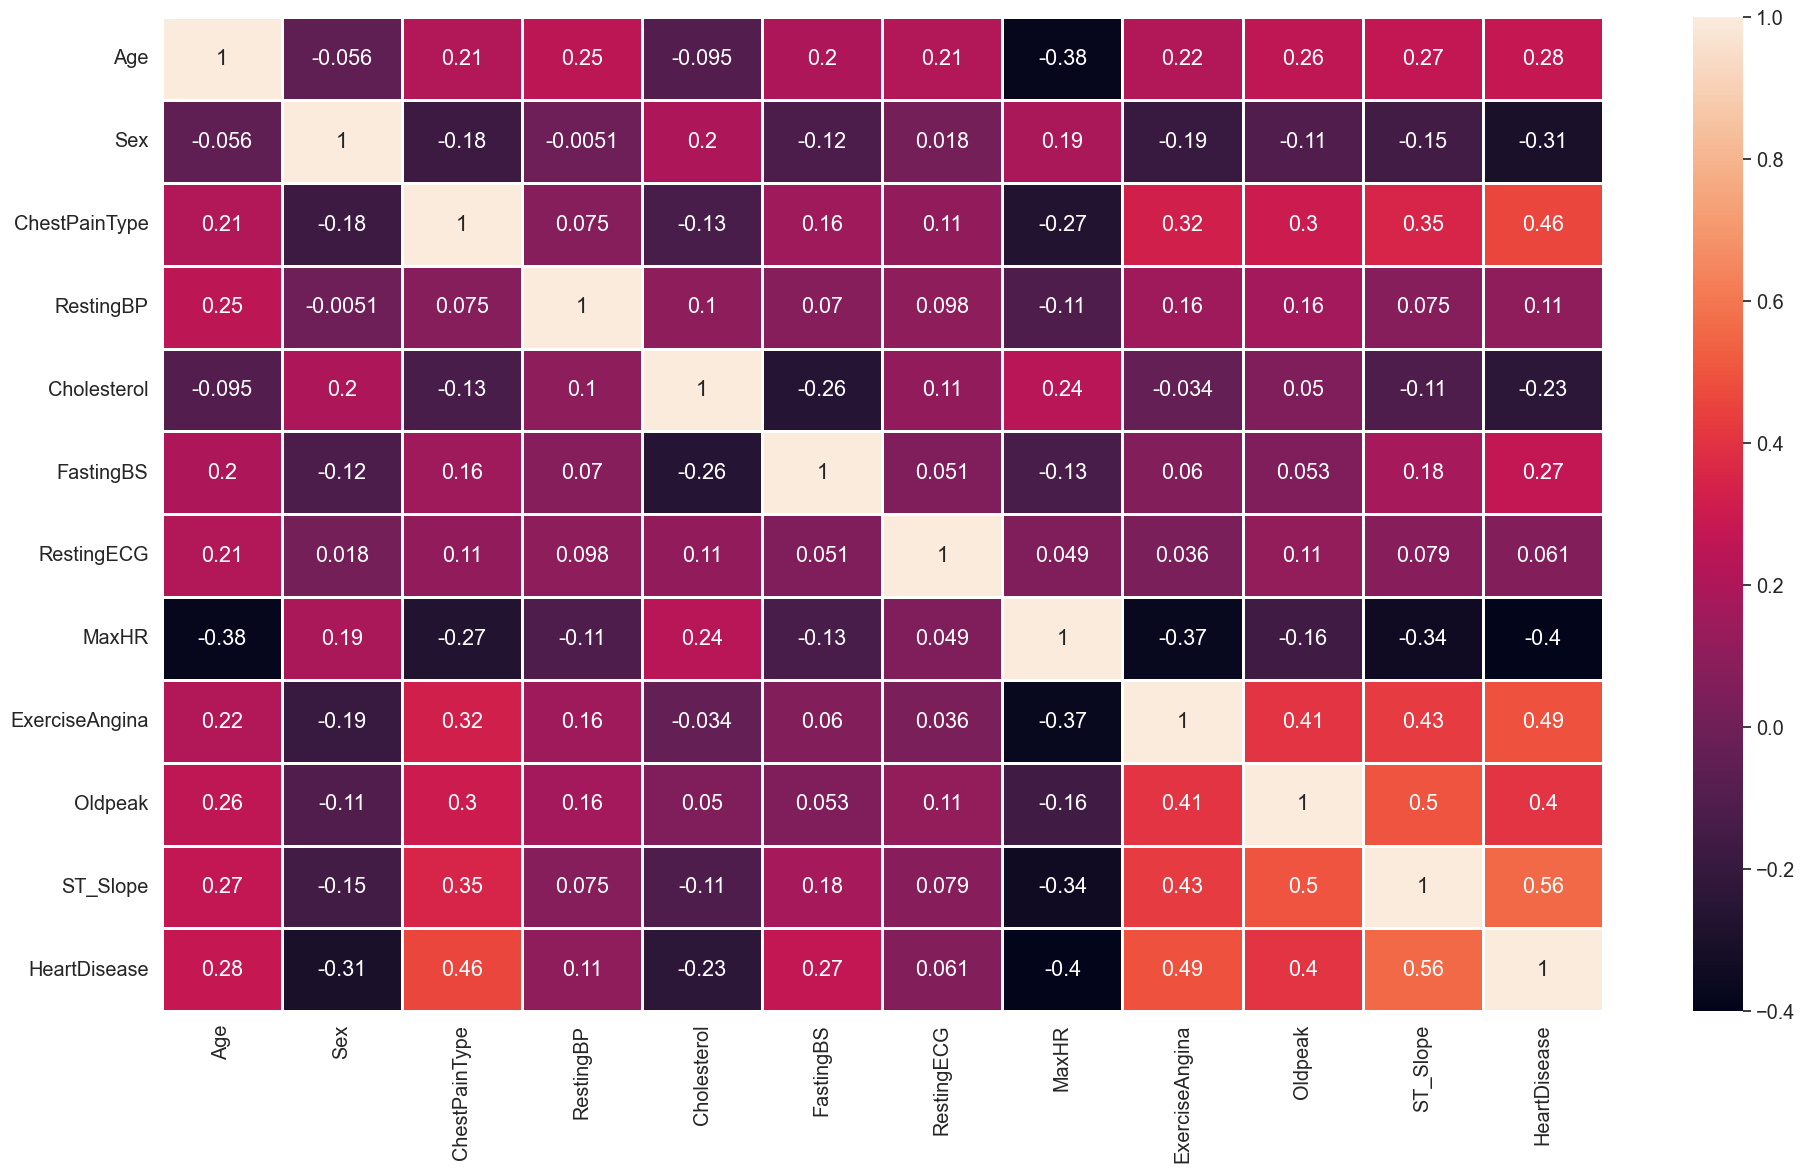

In [770]:
# Generate correlation matrix between all features
plt.figure(figsize=(20,12))
sns.set_context('notebook',font_scale = 1.3)
sns.heatmap(df.corr(),annot=True,linewidth =2)
plt.tight_layout()
plt.savefig('figures/CorrelationMatrix.jpg')

### Uni-variate analysis with the output value

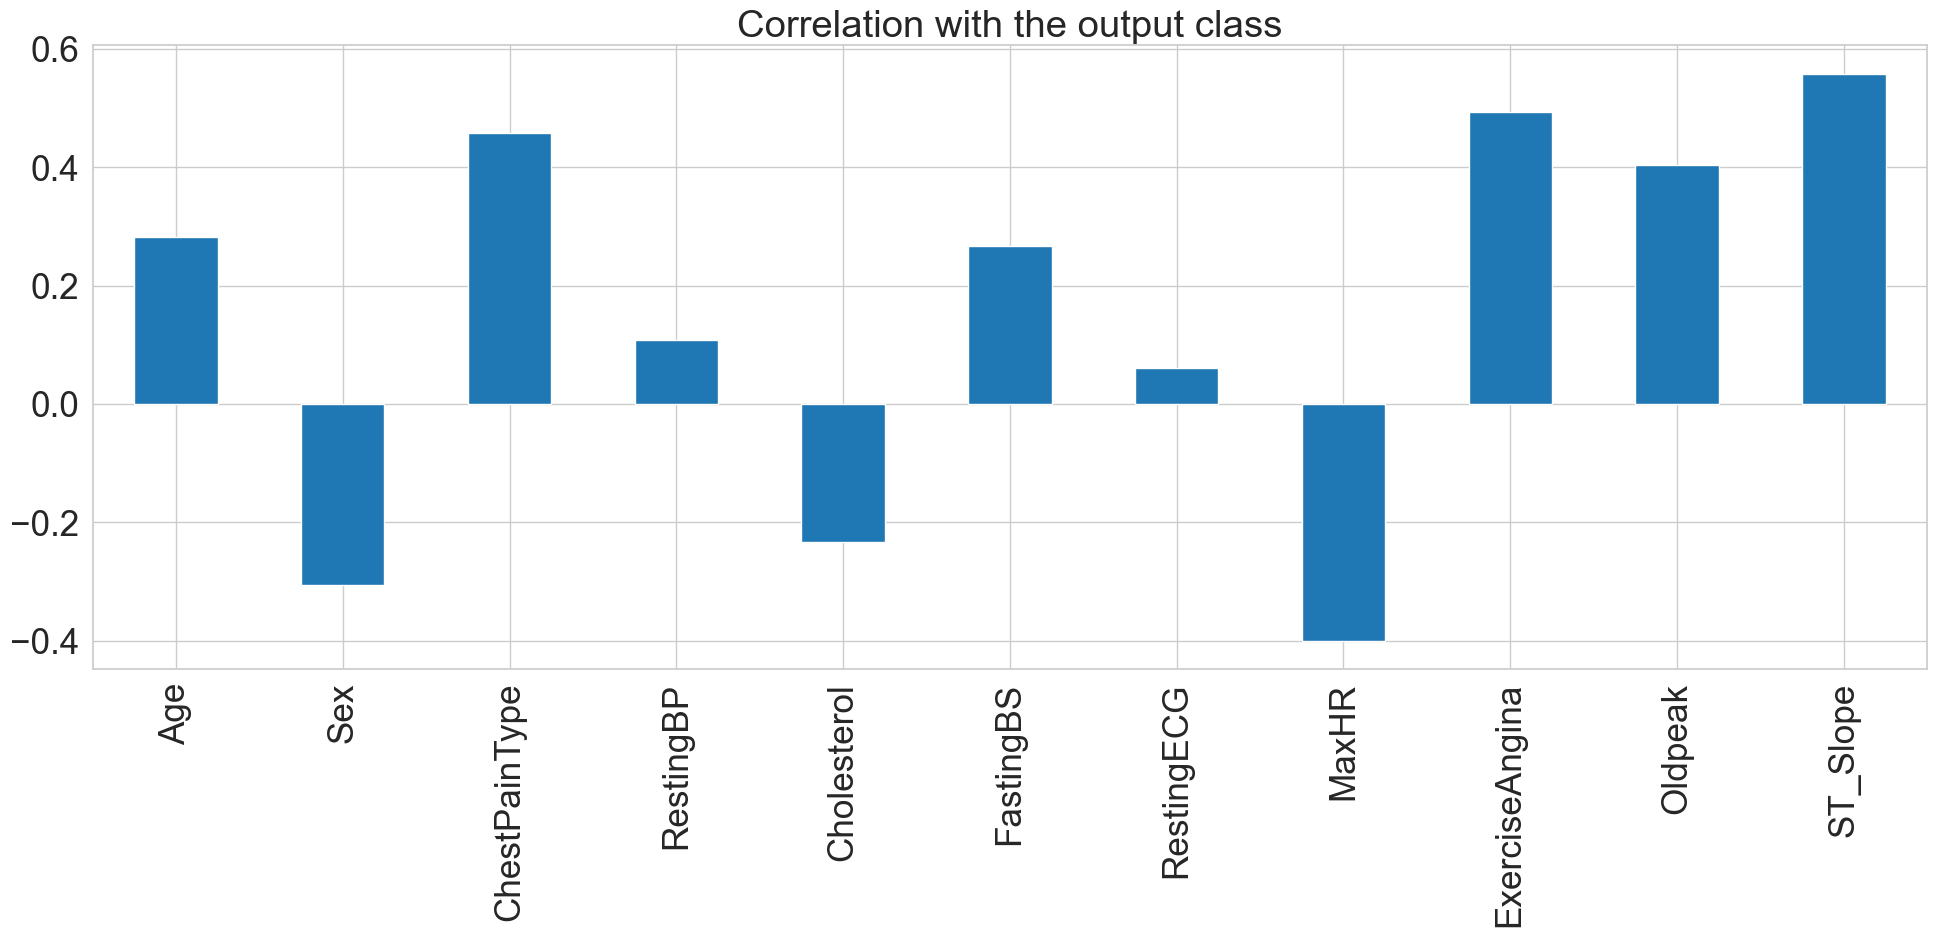

In [771]:
# Identify relationship between each feature and the output class
sns.set_context('notebook',font_scale = 2.3)
df.drop('HeartDisease', axis=1).corrwith(df.HeartDisease).plot(kind='bar', grid=True, figsize=(20, 10), title="Correlation with the output class")
plt.tight_layout()
plt.savefig('figures/OutputCorrelation.jpg')

### Distribution of all features in the given dataset

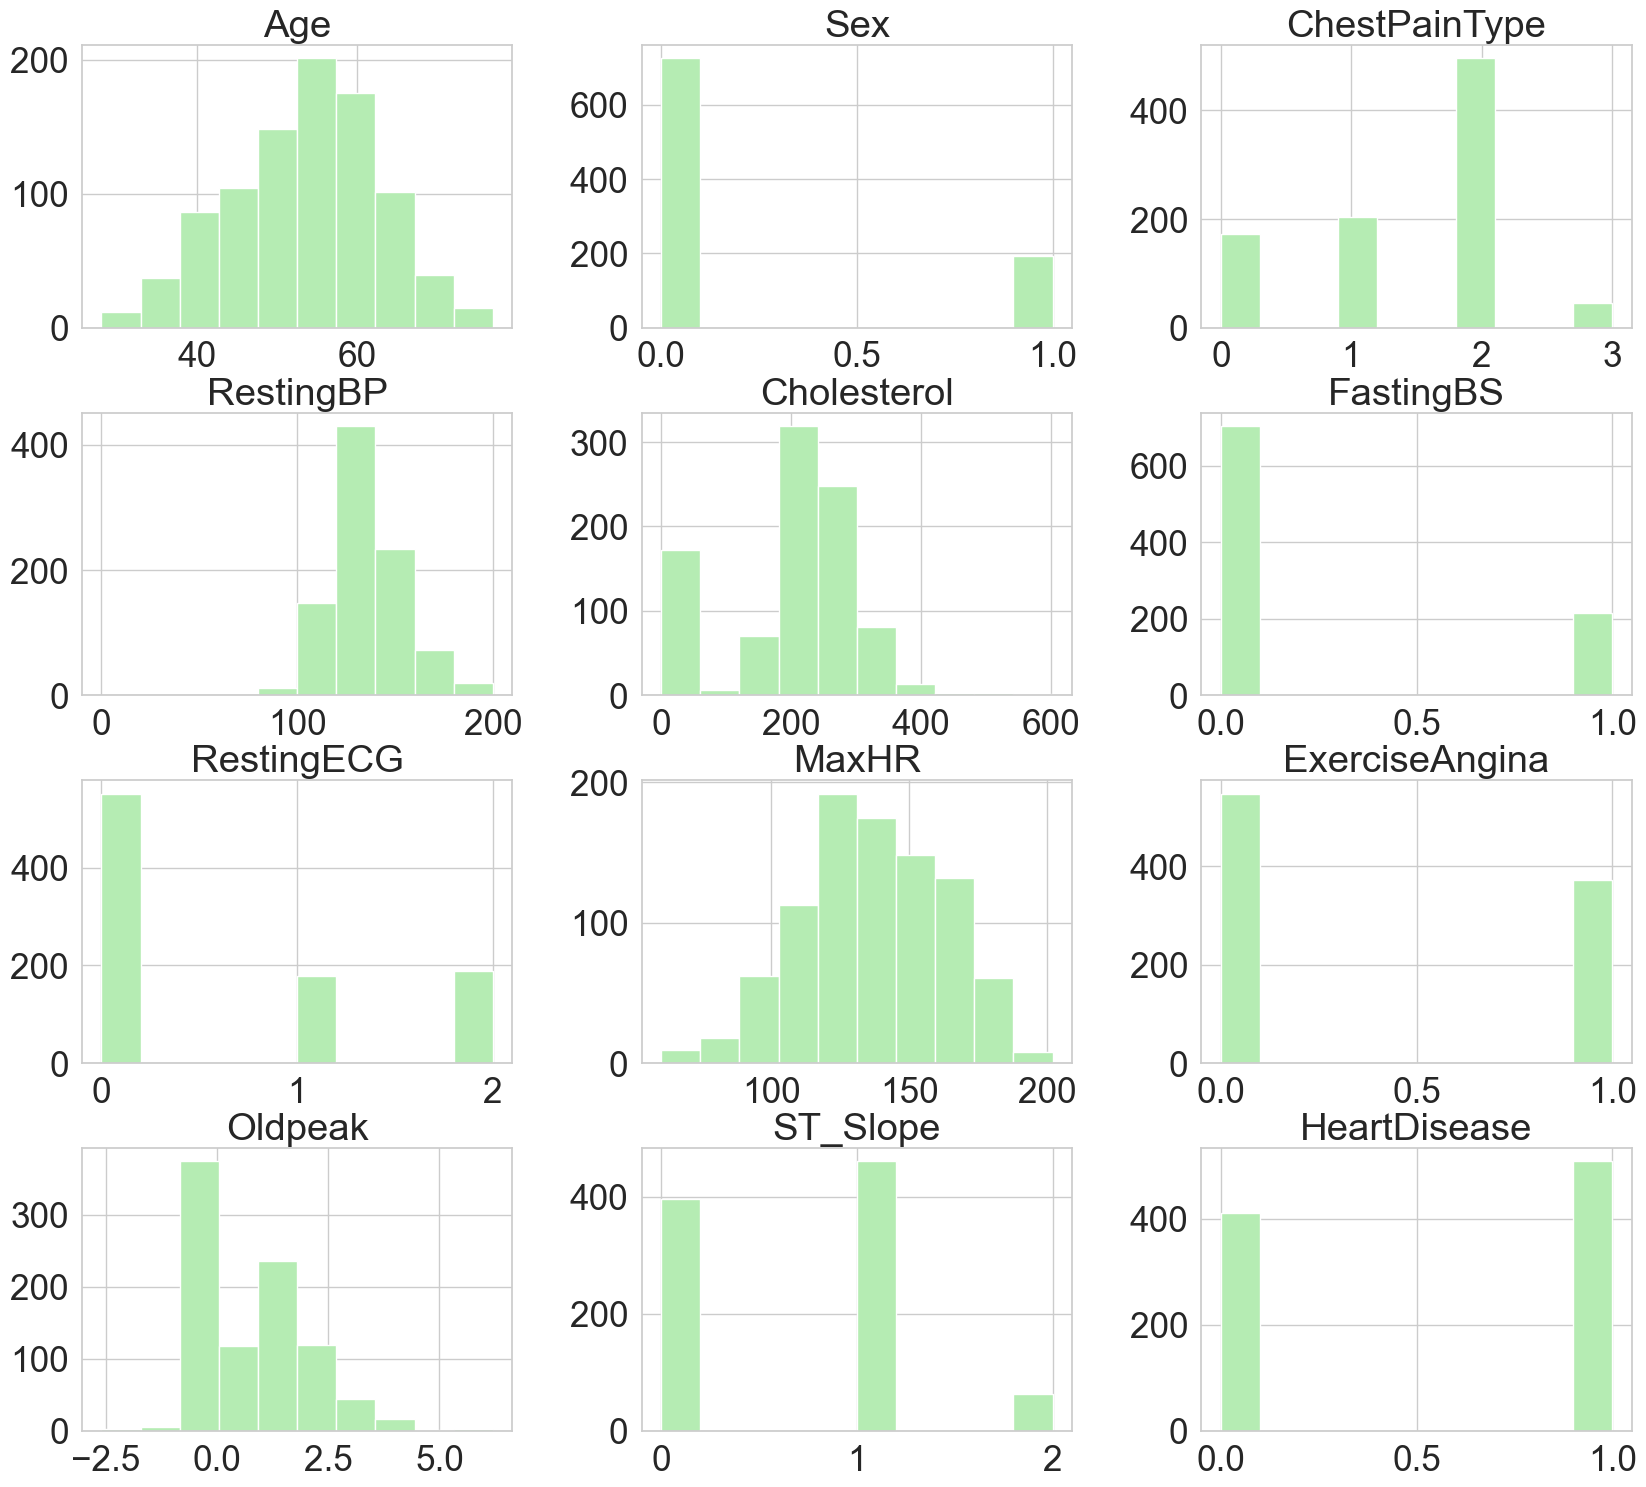

In [772]:
# Find distribution of dataset
df.hist(figsize=(20,18), color = '#B5ECB3')
plt.savefig('figures/HistogramAll.jpg')

A mixture of categorical variables and continuous variables. Continuous variables (age, restingbp, cholesterol, maxhr, oldpeak) need to be scaled since they have different range. Categorical should be divided into dummy columns separating each value.
Another note on the missing value of Cholesterol feature (value = 0): we plan to create 2 models, one with Cholesterol as the feature and the other one without it. We'll then use accuracy to determine if we can drop these missing data tuples.

### Age group analysis using pie charts

<Figure size 5000x4000 with 0 Axes>

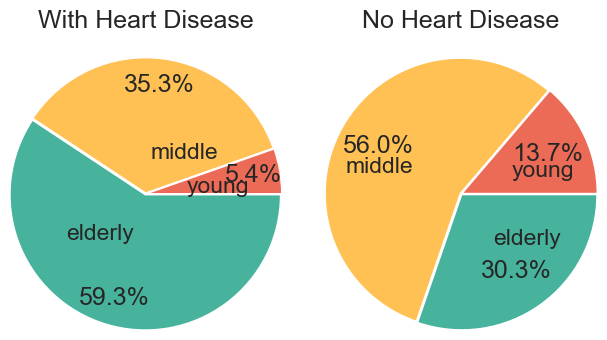

In [773]:
# Plot pie chart for age group vs. heart disease
youngD = df[(df.Age>=28) & (df.Age<40) & (df.HeartDisease==1)]
middleD = df[(df.Age>=40)&(df.Age<55)&(df.HeartDisease==1)]
oldD = df[(df.Age>55)&(df.HeartDisease==1)]

young = df[(df.Age>=28) & (df.Age<40) & (df.HeartDisease==0)]
middle = df[(df.Age>=40)&(df.Age<55)&(df.HeartDisease==0)]
old = df[(df.Age>55)&(df.HeartDisease==0)]

colors = ['#EC6B56','#FFC154','#47B39C']
plt.figure(figsize=(50,40))
sns.set_context('notebook',font_scale = 1.5)
fig, ax = plt.subplots(1,2, sharex='all', sharey='all')

ax[0].pie([len(youngD),len(middleD),len(oldD)],labels=['young','middle','elderly'],colors=colors, explode= [0.01,0.01,0.01], autopct='%1.1f%%', radius = 1.5, pctdistance = 0.8, labeldistance=0.3,center=(0,0))
ax[0].set_title('With Heart Disease', y=1.2, x=0.3)
ax[1].pie([len(young),len(middle),len(old)],labels=['young','middle','elderly'],colors=colors, explode= [0.01,0.01,0.01], autopct='%1.1f%%', radius = 1.5, pctdistance = 0.7, labeldistance=0.4, center=(0.5,0))
ax[1].set_title('No Heart Disease', y=1.2)
plt.savefig('figures/AgeGroupAnalysis.jpg')

The pie chart show that individuals in the elder group (greater than 55) have the highest chance of having heart disease (59.3%). It is then followed by the middle age group between 40 and 55 years old (35.3%) and then younger age group between 28 and 40 years old (5.4%)

Another piece of information from the pie chart with no heart disease, is that middle age and young group combined occupies the majority. This also agrees with the previous finding that the elder group tend to have a high chance of experiencing heart disease.

### Sex analysis using pie chart

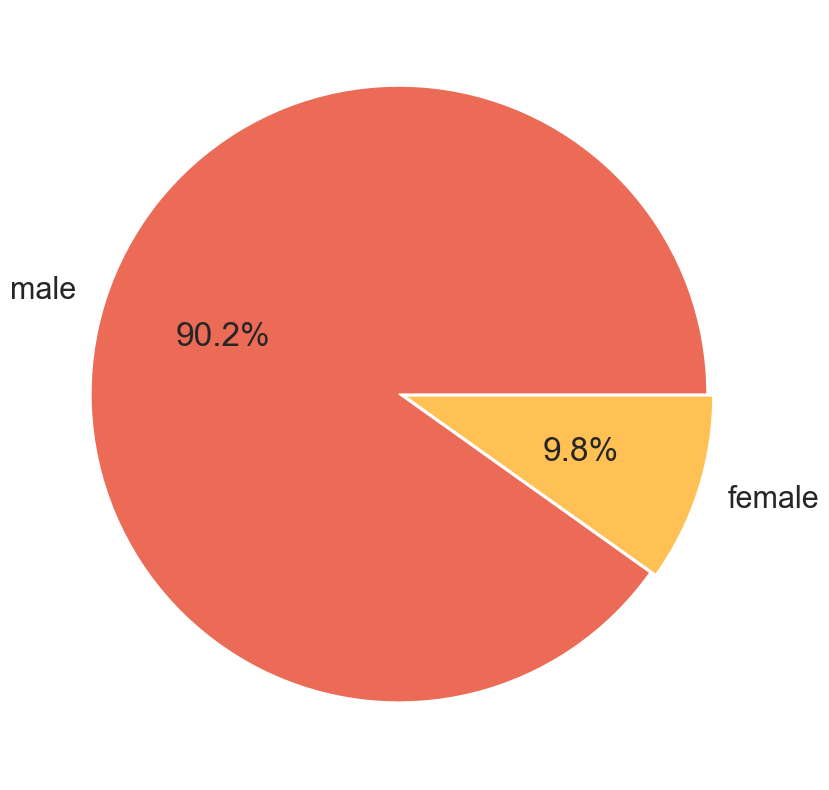

In [774]:
# Plot pie chart for sex vs. heart disease
male = df[(df.Sex==0) & (df.HeartDisease==1)]
female = df[(df.Sex==1)&(df.HeartDisease==1)]

colors = ['#EC6B56','#FFC154']
plt.figure(figsize=(23,10))
sns.set_context('notebook',font_scale = 2)
plt.pie([len(male),len(female)],labels=['male','female'],colors=colors, explode= [0.01,0.01], autopct='%1.1f%%')
plt.savefig('figures/SexAnalysis.jpg')

Even though the pie chart shows that the chances of developing heart disease for Male is much higher than Female, we can't establish a strong relationship between the 2 variables. Note that the histogram shows a skewed distribution towards Male, therefore we can't really draw a precise conclusion from the pie chart alone.

### Chest pain type analysis using pie chart

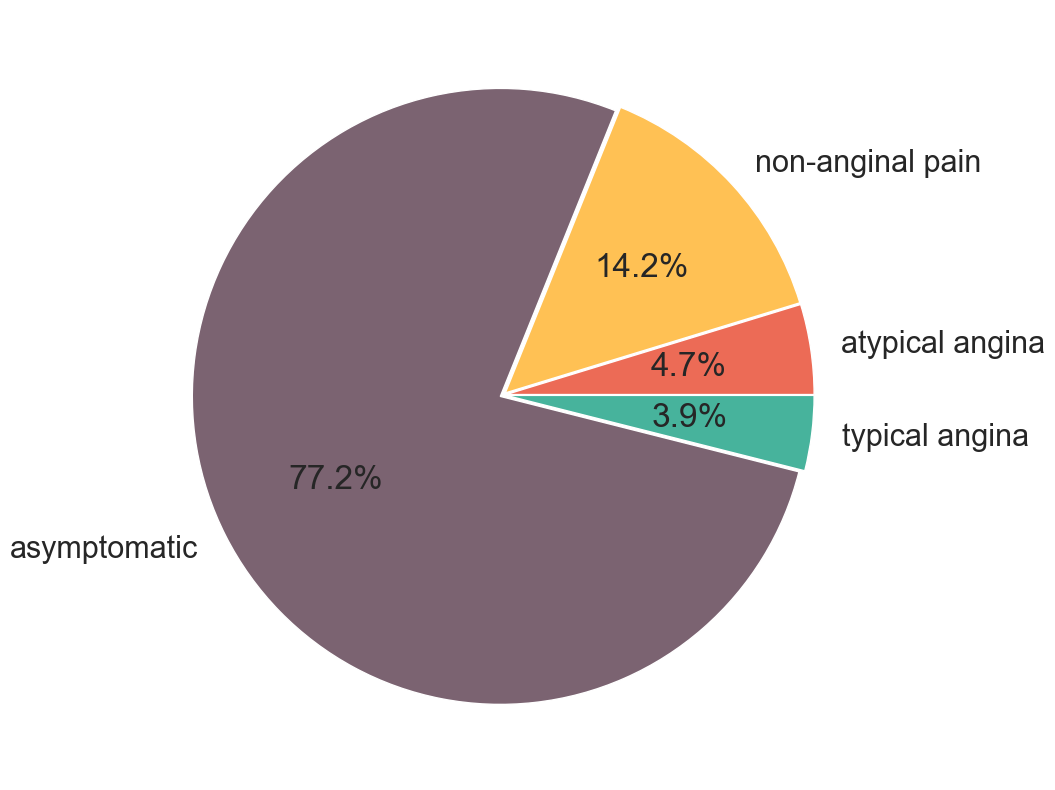

In [775]:
# Plot pie chart for sex vs. heart disease
# 0 denote atypical angina (ATA)
# 1 denote non-anginal pain (NAP)
# 2 denote asymptomatic (ASY)
# 3 denote typical angina (TA)
ata = df[(df.ChestPainType==0) & (df.HeartDisease==1)]
nap = df[(df.ChestPainType==1) & (df.HeartDisease==1)]
asy = df[(df.ChestPainType==2) & (df.HeartDisease==1)]
ta = df[(df.ChestPainType==3) & (df.HeartDisease==1)]

colors = ['#EC6B56','#FFC154','#7b6371', '#47B39C']
plt.figure(figsize=(23,10))
sns.set_context('notebook',font_scale = 2)
plt.pie([len(ata),len(nap), len(asy), len(ta)],labels=['atypical angina','non-anginal pain', 'asymptomatic', 'typical angina'],colors=colors, explode= [0.01,0.01, 0.01, 0.01], autopct='%1.1f%%')
plt.savefig('figures/ChestPainTypeAnalysis.jpg')

The pie chart shows that most patients having heart disease don't experience any significant symptoms. The result agrees with the literature that most heart attacks are silent heart attacks (damage is done, but no symptoms).

In [776]:
# Identify and remove missing values from RestingBP
print("Count of missing values for resting blood pressure (value = 0): ",
      len(df[df['RestingBP'] == 0]))
missingBP = df[df['RestingBP'] == 0]
df.drop(missingBP.index, inplace=True)
assert df['RestingBP'].min() != 0
print("After reduction of 1 data tuple, the shape decreases by 1 row: ", df.shape)

Count of missing values for resting blood pressure (value = 0):  1
After reduction of 1 data tuple, the shape decreases by 1 row:  (917, 12)


### Resting blood pressure analysis using boxplot

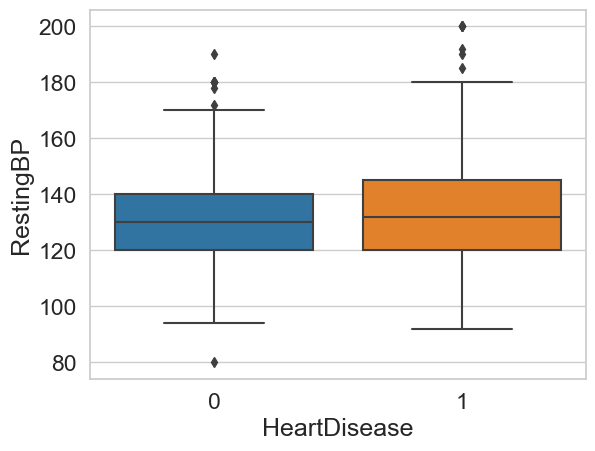

In [777]:
# boxplot of restingBP vs. Heart Disease
sns.set_context('notebook',font_scale = 1.5)
sns.boxplot(x=df['HeartDisease'], y=df['RestingBP'])
plt.savefig('figures/RestingBPAnalysisBoxplot.jpg')

The boxplot shows a slightly higher average resting blood pressure for those with heart disease. Therefore, it is hard to determine if resting blood pressure plays a significant role in indicating heart disease.

### Resting blood pressure analysis using pie charts

Count of data tuples with low blood pressure (value < 90):  1


<Figure size 2000x2000 with 0 Axes>

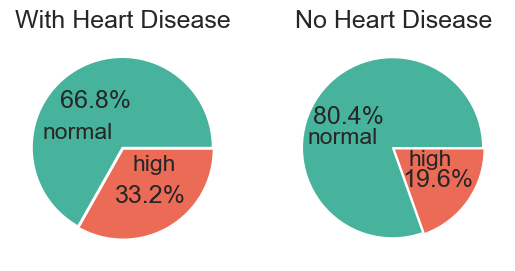

In [778]:
print("Count of data tuples with low blood pressure (value < 90): ",
      len(df[df['RestingBP'] < 90]))

normalBPD = df[(df.RestingBP<140) & (df.HeartDisease==1)]
highBPD = df[(df.RestingBP>140) & (df.HeartDisease==1)]

normalBP = df[(df.RestingBP<140) & (df.HeartDisease==0)]
highBP = df[(df.RestingBP>140) & (df.HeartDisease==0)]

colors = ['#47B39C','#EC6B56']
plt.figure(figsize=(20,20))
sns.set_context('notebook',font_scale = 1.5)
fig, ax = plt.subplots(1,2, sharex='all', sharey='all')

ax[0].pie([len(normalBPD),len(highBPD)],labels=['normal','high'],colors=colors, explode= [0.01,0.01], autopct='%1.1f%%', labeldistance = 0.2)
ax[0].set_title('With Heart Disease')
ax[1].pie([len(normalBP),len(highBP)],labels=['normal','high'],colors=colors, explode= [0.01,0.01], autopct='%1.1f%%', labeldistance = 0.2)
ax[1].set_title('No Heart Disease')
plt.savefig('figures/RestingBPAnalysisPie.jpg')

Since there is only 1 data tuple belonging to low blood pressure threshold (less than 90), we include this data tuple in the normal blood pressure group.

The pie chart shows that the percentage of individuals with high blood pressure (33.2%) is much higher than that with low blood pressure (19.6%). It performs better at showing the high blood pressure as an important feature in heart disease diagnosis.

### Fasting blood sugar analysis

In [779]:
# Fasting blood sugar analysis


### Resting electro-cardiograph (ECG) analysis

<Figure size 5000x4000 with 0 Axes>

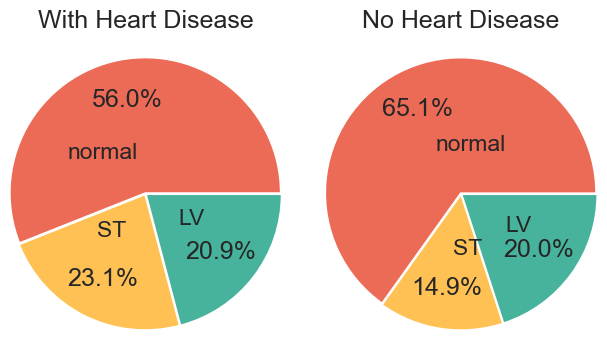

In [780]:
normalD = df[(df.RestingECG==0) & (df.HeartDisease==1)]
stD = df[(df.RestingECG==1)&(df.HeartDisease==1)]
lvD = df[(df.RestingECG==2)&(df.HeartDisease==1)]

normal = df[(df.RestingECG==0) & (df.HeartDisease==0)]
st = df[(df.RestingECG==1)&(df.HeartDisease==0)]
lv = df[(df.RestingECG==2)&(df.HeartDisease==0)]

colors = ['#EC6B56','#FFC154','#47B39C']
plt.figure(figsize=(50,40))
sns.set_context('notebook',font_scale = 1.5)
fig, ax = plt.subplots(1,2, sharex='all', sharey='all')

ax[0].pie([len(normalD),len(stD),len(lvD)],labels=['normal','ST','LV'],colors=colors, explode= [0.01,0.01,0.01], autopct='%1.1f%%', radius = 1.5, pctdistance = 0.7, labeldistance=0.3,center=(0,0))
ax[0].set_title('With Heart Disease', y=1.2, x=0.3)
ax[1].pie([len(normal),len(st),len(lv)],labels=['normal','ST','LV'],colors=colors, explode= [0.01,0.01,0.01], autopct='%1.1f%%', radius = 1.5, pctdistance = 0.7, labeldistance=0.4, center=(0.5,0))
ax[1].set_title('No Heart Disease', y=1.2)
plt.savefig('figures/RestingECGAnalysis.jpg')

For individuals with normal resting ECG, there is no significant difference between the groups with and without heart disease. This finding is consistent with individuals with left ventricular hypertrophy. However, individuals with ST-T wave abnormality shows a higher percentage for those with heart disease. This finding indicates that resting ECG might take part in diagnosign heart disease.

### Max heart rate (HR) analysis

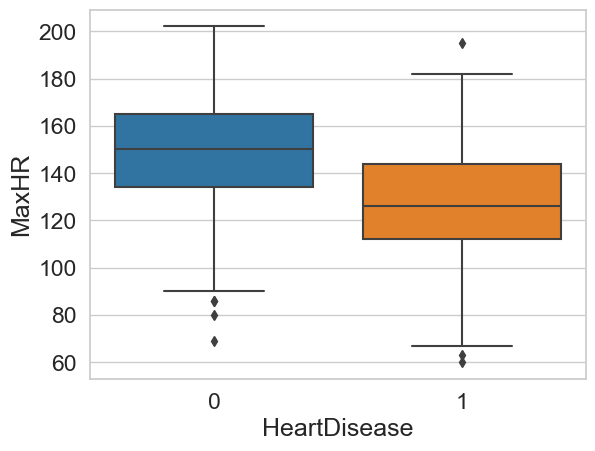

In [781]:
# boxplot of MaxHR vs. Heart Disease
sns.set_context('notebook',font_scale = 1.5)
sns.boxplot(x=df['HeartDisease'], y=df['MaxHR'])
plt.savefig('figures/MaxHRAnalysis.jpg')

The boxplot clearly shows that individuals with heart disease have a higher maximum heart rate on average (150), as compared to those with no heart disease (130). This finding indicates the maximum heart rate feature takes an important role in diagnosing heart disease.

### Exercise angina analysis

<Figure size 2000x2000 with 0 Axes>

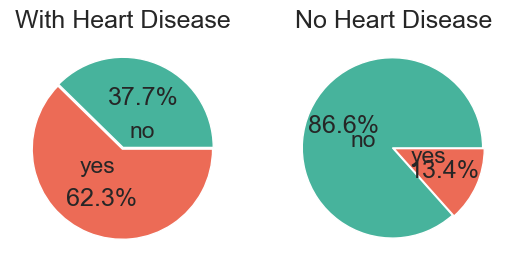

In [782]:
eanD = df[(df.ExerciseAngina==0) & (df.HeartDisease==1)]
eayD = df[(df.ExerciseAngina==1) & (df.HeartDisease==1)]

ean = df[(df.ExerciseAngina==0) & (df.HeartDisease==0)]
eay = df[(df.ExerciseAngina==1) & (df.HeartDisease==0)]

colors = ['#47B39C','#EC6B56']
plt.figure(figsize=(20,20))
sns.set_context('notebook',font_scale = 1.5)
fig, ax = plt.subplots(1,2, sharex='all', sharey='all')

ax[0].pie([len(eanD),len(eayD)],labels=['no','yes'],colors=colors, explode= [0.01,0.01], autopct='%1.1f%%', labeldistance = 0.2)
ax[0].set_title('With Heart Disease')
ax[1].pie([len(ean),len(eay)],labels=['no','yes'],colors=colors, explode= [0.01,0.01], autopct='%1.1f%%', labeldistance = 0.2)
ax[1].set_title('No Heart Disease')
plt.savefig('figures/ExerciseAnginaAnalysis.jpg')

the pie charts clearly illustrate that individuals who experience exercise angina have a higher chance of carrying heart disease (62.3% vs. 13.4%. This finding shows a significant impact of exercise angina in diagnosing heart disease.

### Create dummy columns for each categorical variables

In [783]:
# # Create dummies columns for categorical variable, to be used for machine learning algorithm
# df = pd.get_dummies(df, columns = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])
# print(df.head())


The dummies columns are created for each categorical variable. The dataset now contains 22 columns.

### Normalize all continuous variable using MinMaxScaler

In [784]:
# # Scale continuous variables to range [0,1]
# scaler = MinMaxScaler()
# columns_to_scale = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
# df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
# df[columns_to_scale].hist(figsize=(10,10), color = '#B5ECB3')
# plt.savefig('figures/Normalized.jpg')

The range for each continuous variable is within range [0,1] as expected.